#Predicting Methane Emissions from Landfill Waste Composition in African Countries

I chose specifically this use case because it aligns well with my mission as methane from landfills is a major contributor to climate change, and understanding emission patterns can help design better waste management strategies.

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from google.colab import drive
import joblib
from pathlib import Path

# Load the dataset
drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/MyDrive/ML-Math-Summative/country_level_data_0.csv'
df = pd.read_csv(file_path)

# Filter for African countries
african_countries = [
     'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
    'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros',
    'Congo, Dem. Rep.', 'Congo, Rep.', 'Côte d’Ivoire', 'Djibouti',
    'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon',
    'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
    'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco',
    'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe',
    'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa',
    'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'
]
africa_df = df[df['country_name'].isin(african_countries)].copy()

# Convert waste composition percentages to numeric
waste_types = [
    'composition_food_organic_waste_percent',
    'composition_glass_percent',
    'composition_metal_percent',
    'composition_paper_cardboard_percent',
    'composition_other_percent',
    'composition_plastic_percent',
    'composition_rubber_leather_percent',
    'composition_wood_percent',
    'composition_yard_garden_green_waste_percent'
]

for col in waste_types:
    africa_df[col] = pd.to_numeric(
        africa_df[col].astype(str).str.replace('%', '', regex=False),
        errors='coerce'
    )

# Fill missing values with median for numeric columns
numeric_cols = africa_df.select_dtypes(include=[np.number]).columns
africa_df[numeric_cols] = africa_df[numeric_cols].fillna(africa_df[numeric_cols].median())

# One-hot encode categorical variables (adjusting for your actual categorical columns)
categorical_cols = [
    'income_id',
    'other_information_information_system_for_solid_waste_management',
    'other_information_national_agency_to_enforce_solid_waste_laws_and_regulations',
    'other_information_national_law_governing_solid_waste_management_in_the_country',
    'other_information_ppp_rules_and_regulations'
]

for col in categorical_cols:
    if col in africa_df.columns:
        africa_df = pd.get_dummies(africa_df, columns=[col], prefix=col)

Mounted at /content/drive


### Exploratory Data Analysis and Visualization

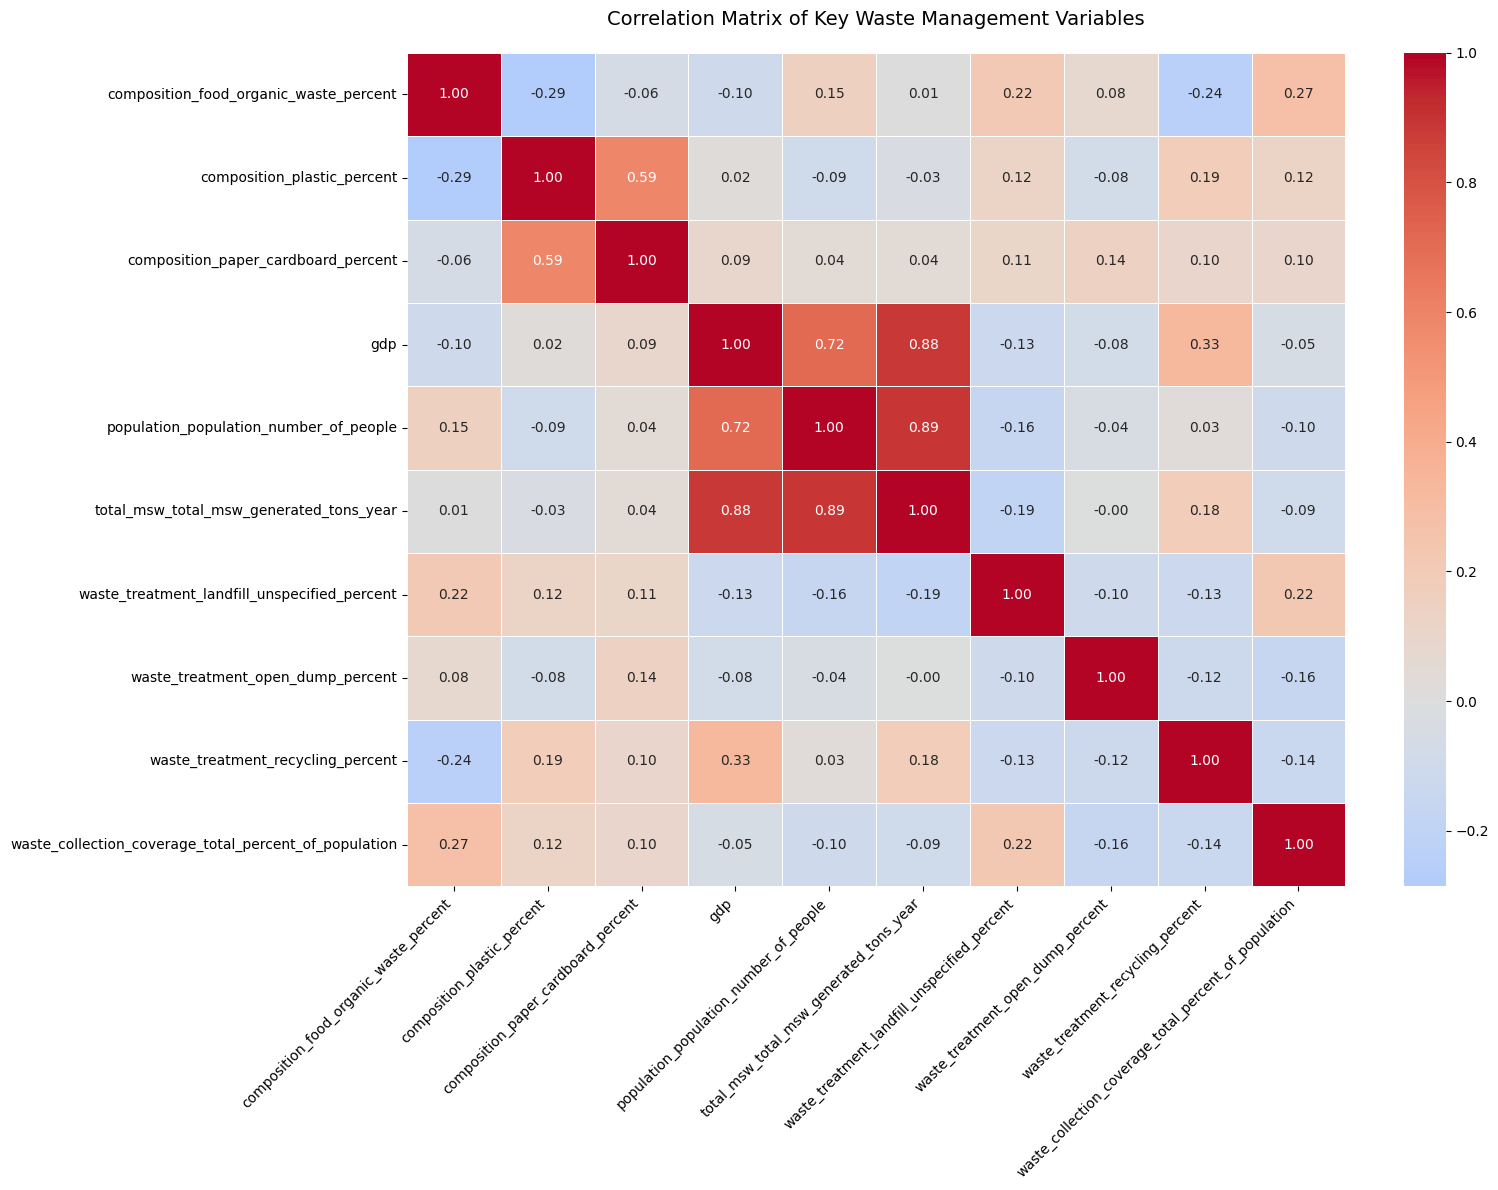

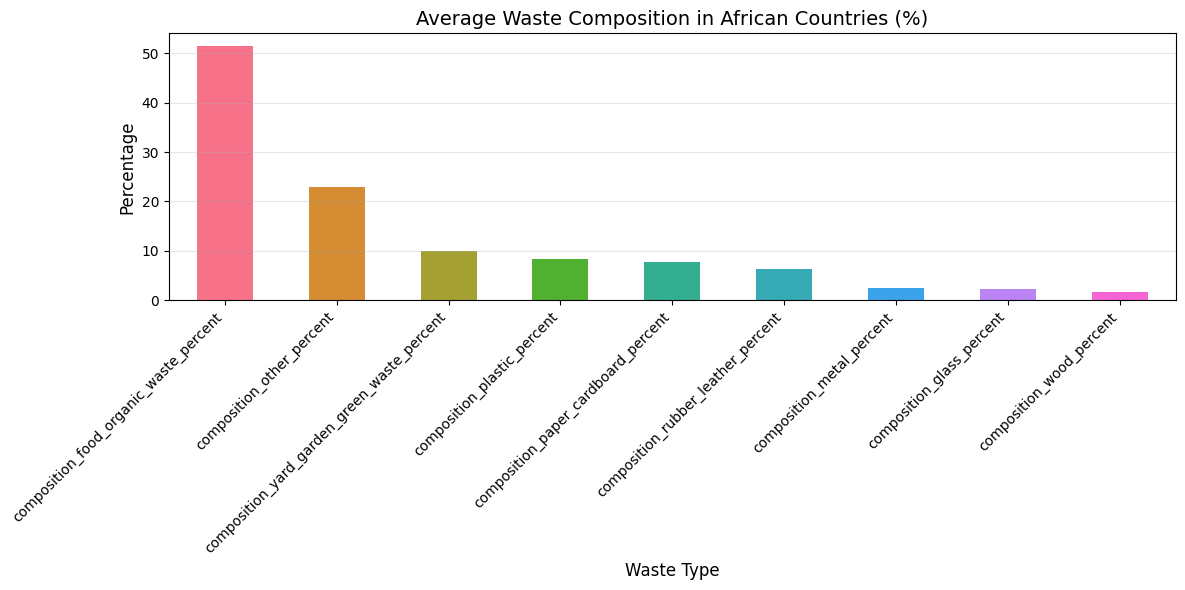

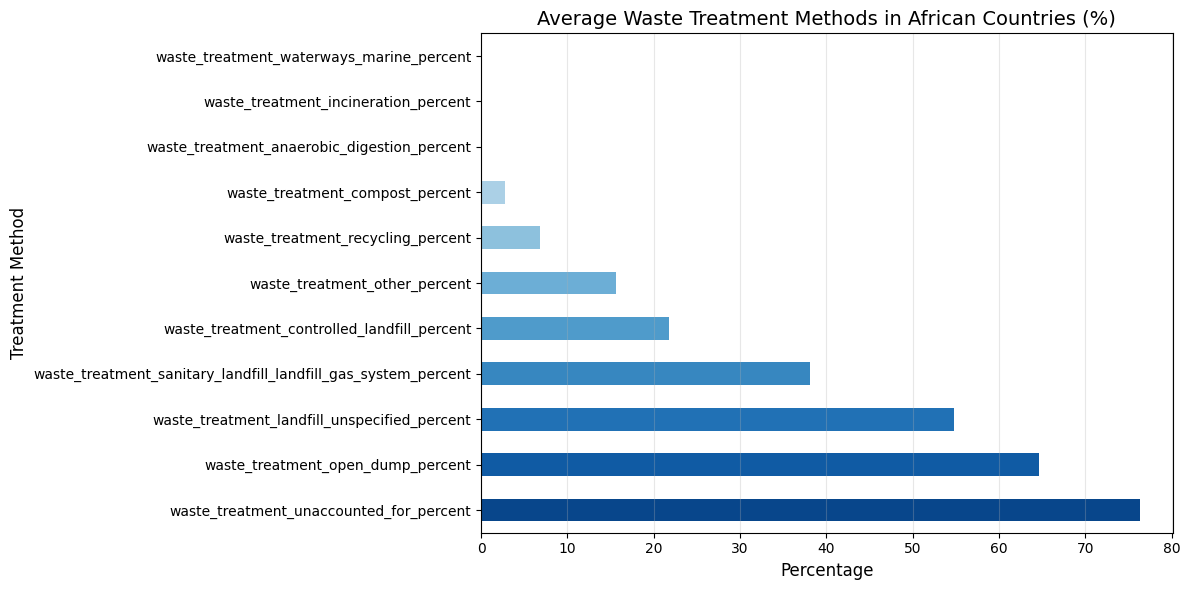

In [3]:
# Exploratory Data Analysis and Visualization

# 1. Correlation Heatmap (using only numeric columns)
plt.figure(figsize=(16,12))
numeric_df = africa_df.select_dtypes(include=[np.number])

# We'll focus on columns that are likely to be most relevant
selected_numeric_cols = [
    'composition_food_organic_waste_percent',
    'composition_plastic_percent',
    'composition_paper_cardboard_percent',
    'gdp',
    'population_population_number_of_people',
    'total_msw_total_msw_generated_tons_year',
    'waste_treatment_landfill_unspecified_percent',
    'waste_treatment_open_dump_percent',
    'waste_treatment_recycling_percent',
    'waste_collection_coverage_total_percent_of_population'
]

# Calculate correlation matrix
corr_matrix = numeric_df[selected_numeric_cols].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f',
            annot_kws={'size': 10}, linewidths=0.5)
plt.title('Correlation Matrix of Key Waste Management Variables', pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Composition Breakdown for African Countries
# Calculate mean composition percentages
composition_cols = [col for col in africa_df.columns if 'composition_' in col and '_percent' in col]
composition_means = africa_df[composition_cols].mean().sort_values(ascending=False)

# Plot composition breakdown
plt.figure(figsize=(12,6))
composition_means.plot(kind='bar', color=sns.color_palette('husl', len(composition_cols)))
plt.title('Average Waste Composition in African Countries (%)', fontsize=14)
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Waste Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Waste Treatment Methods Visualization
treatment_cols = [col for col in africa_df.columns if 'waste_treatment_' in col and '_percent' in col]
treatment_means = africa_df[treatment_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
treatment_means.plot(kind='barh', color=sns.color_palette('Blues_r', len(treatment_cols)))
plt.title('Average Waste Treatment Methods in African Countries (%)', fontsize=14)
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Treatment Method', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
# Define target variable - using total MSW generated as target
target = 'total_msw_total_msw_generated_tons_year'
if target not in africa_df.columns:
    # Fallback target if the preferred one isn't available
    target = 'special_waste_industrial_waste_tons_year'

# Prepare features and target
X = africa_df.drop([
    'iso3c', 'region_id', 'country_name',  # identifiers
    'where_where_is_this_data_measured',   # metadata
    'other_information_summary_of_key_solid_waste_information_made_available_to_the_public',  # text field
    target  # target variable
], axis=1, errors='ignore')

y = africa_df[target]

### Feature Importance

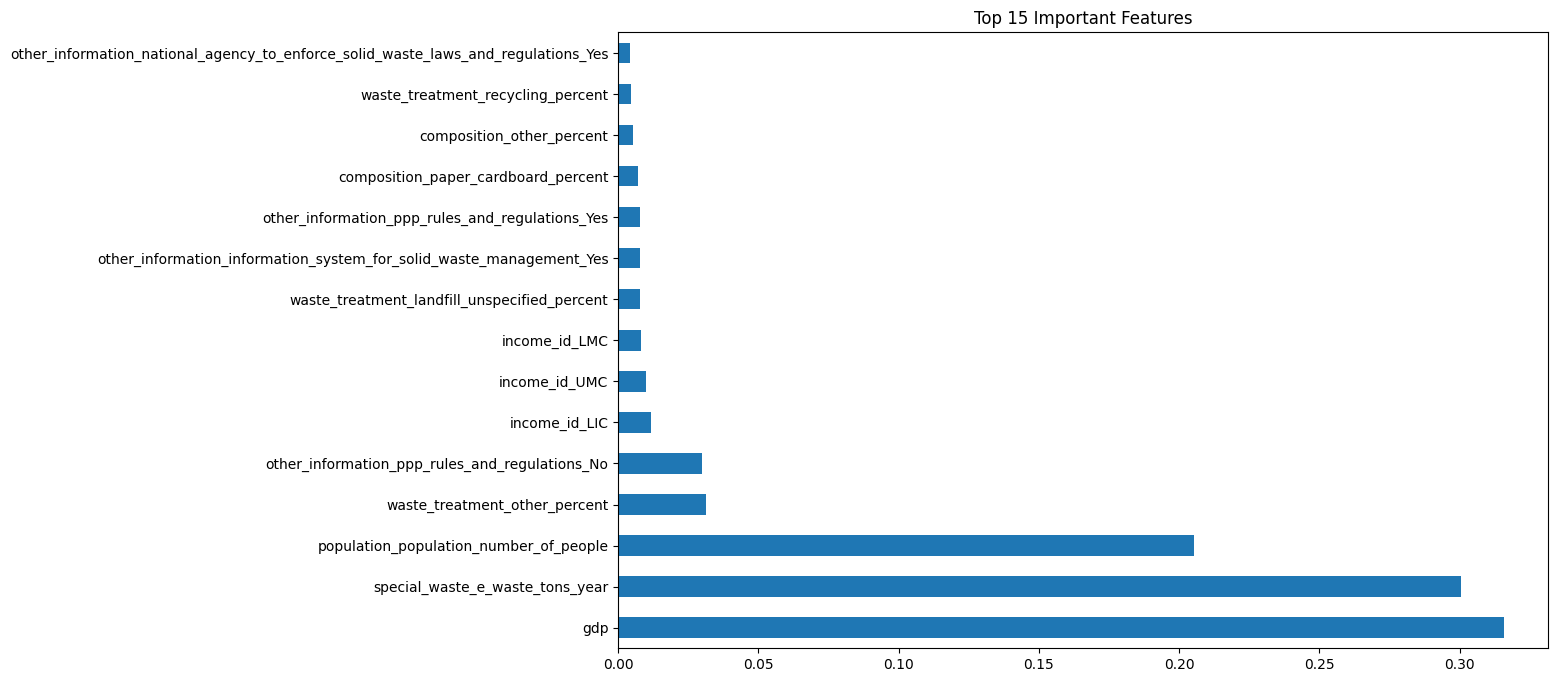

In [5]:
# Feature selection using Extra Trees
et_model = ExtraTreesRegressor(random_state=42)
et_model.fit(X, y)

# Plot feature importance
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(et_model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Top 15 Important Features')
plt.show()

# Select top features (adjust number as needed)
selected_features = feat_importances.nlargest(10).index.tolist()
X = X[selected_features]

### Standardizing data

In [6]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Custom SGDRegressor to track loss
class CustomSGDRegressor(SGDRegressor):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_history_ = []

    def partial_fit(self, X, y):
        super().partial_fit(X, y)
        self.loss_history_.append(mean_squared_error(y, self.predict(X)))
        return self

### Train Linear Regression Model with Gradient Descent

In [7]:
# Train Linear Regression with SGD
lr_model = CustomSGDRegressor(
    max_iter=1,
    tol=-np.inf,
    warm_start=True,
    eta0=0.01,
    random_state=42
)

train_loss, test_loss = [], []

for _ in range(300):
    lr_model.partial_fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, lr_model.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, lr_model.predict(X_test)))


### Plot Loss Curve

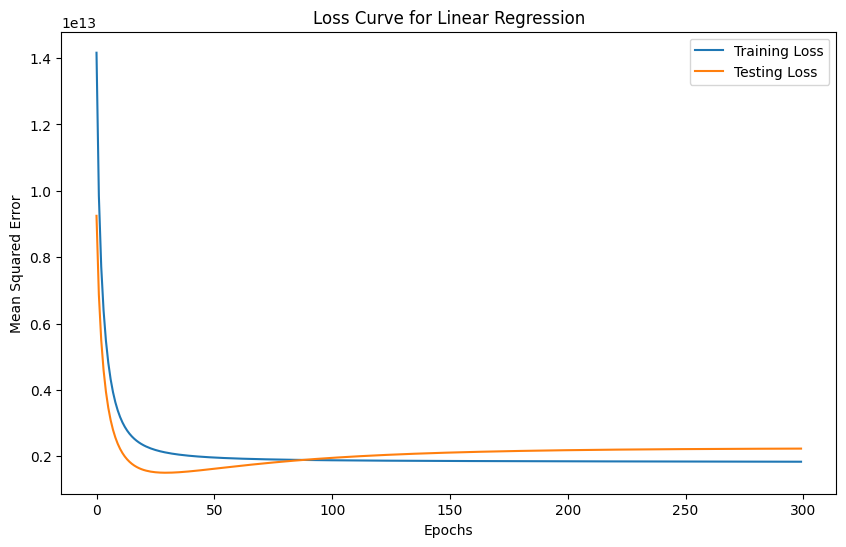

In [8]:
# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Loss Curve for Linear Regression')
plt.legend()
plt.show()

### Before/After Scatter Plot

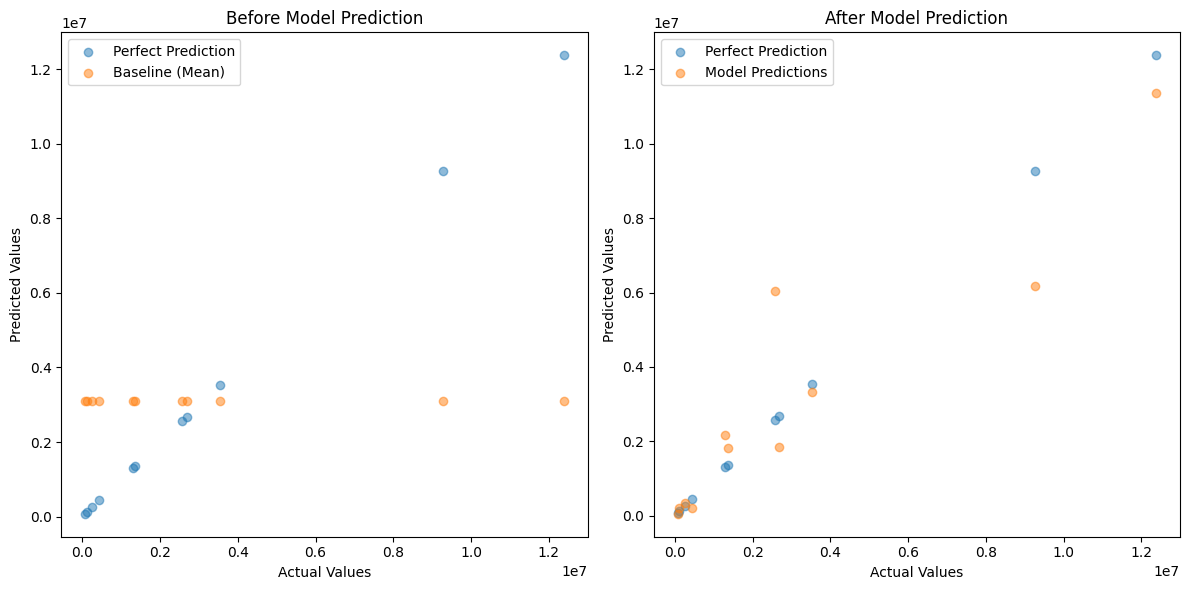

In [9]:
y_pred = lr_model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test, alpha=0.5, label='Perfect Prediction')
plt.scatter(y_test, [np.mean(y_test)]*len(y_test), alpha=0.5, label='Baseline (Mean)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Before Model Prediction')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test, alpha=0.5, label='Perfect Prediction')
plt.scatter(y_test, y_pred, alpha=0.5, label='Model Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('After Model Prediction')
plt.legend()
plt.tight_layout()
plt.show()

### Compare with Decision Tree and Random Forest

In [10]:
# Compare with Decision Tree and Random Forest
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_pred)

rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)

lr_mse = mean_squared_error(y_test, y_pred)

print(f"Linear Regression MSE: {lr_mse}")
print(f"Decision Tree MSE: {dt_mse}")
print(f"Random Forest MSE: {rf_mse}")

Linear Regression MSE: 2232492192757.9414
Decision Tree MSE: 4104545482637.0264
Random Forest MSE: 2399814422643.831


### Save Best Performing Model

In [11]:
# Save the best performing model (assuming Random Forest is best)
best_model = rf_model
joblib.dump(best_model, 'waste_emission_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_features, 'selected_features.pkl')

# Create prediction function
def predict_emission(input_data):
    """Predict waste emission based on input features"""
    # Load artifacts
    model = joblib.load('waste_emission_model.pkl')
    scaler = joblib.load('scaler.pkl')
    features = joblib.load('selected_features.pkl')

    # Create input DataFrame
    input_df = pd.DataFrame([input_data])

    # Ensure all features are present
    for feature in features:
        if feature not in input_df.columns:
            input_df[feature] = 0  # default value for missing features

    # Reorder columns to match training
    input_df = input_df[features]

    # Scale the data
    scaled_data = scaler.transform(input_df)

    # Make prediction
    prediction = model.predict(scaled_data)

    return prediction[0]

# Example usage
sample_input = {
    'composition_food_organic_waste_percent': 45.6,
    'gdp': 2500,
    'population_population_number_of_people': 5000000,
    'waste_treatment_landfill_unspecified_percent': 30,
    'waste_collection_coverage_total_percent_of_population': 70
}

# Fill missing features with median values from training
for feature in selected_features:
    if feature not in sample_input:
        sample_input[feature] = africa_df[feature].median()

emission = predict_emission(sample_input)
print(f"Predicted waste emission: {emission:.2f} tons/year")

Predicted waste emission: 1848960.12 tons/year


In [12]:

waste_cols = [
   'composition_food_organic_waste_percent',
    'composition_glass_percent',
    'composition_metal_percent',
    'composition_paper_cardboard_percent',
    'composition_other_percent',
    'composition_plastic_percent',
    'composition_rubber_leather_percent',
    'composition_wood_percent',
    'composition_yard_garden_green_waste_percent',
    'waste_treatment_landfill_unspecified_percent',
    'waste_collection_coverage_total_percent_of_population'
]

for col in waste_cols:
    africa_df[col] = pd.to_numeric(
        africa_df[col].astype(str).str.replace('%', '', regex=False),
        errors='coerce'
    )

# Use 'total_msw_total_msw_generated_tons_year' as a target instead of missing column
target_column = 'total_msw_total_msw_generated_tons_year'

# Define selected features (choose only from available columns)
selected_features = [
    'composition_food_organic_waste_percent',
    'population_population_number_of_people',
    'gdp',
    'waste_treatment_landfill_unspecified_percent'
]

# Drop rows with missing values
africa_df = africa_df.dropna(subset=selected_features + [target_column])

# Prepare data
X = africa_df[selected_features]
y = africa_df[target_column]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_scaled, y)

# Save model, scaler, and feature list to Drive
joblib.dump(rf_model, '/content/drive/MyDrive/ML-Math-Summative/waste_emission_model.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/ML-Math-Summative/scaler.pkl')
joblib.dump(selected_features, '/content/drive/MyDrive/ML-Math-Summative/selected_features.pkl')

print("Model, scaler, and features saved successfully.")

Model, scaler, and features saved successfully.
